# Working with historic data from Alpaca

In [2]:
import asyncio
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.data.enums import DataFeed
from alpaca.data.timeframe import TimeFrame
import matplotlib.pyplot as plt
from datetime import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest

# Load environment variables
load_dotenv()  # Load .env file

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

# Initialize TradingClient
Trading_Client = TradingClient(API_KEY, API_SECRET, paper=True)  # paper=True for paper trading
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

In [4]:
# --- Strategy Parameters & Costs ---
SYMBOL = "NVDA"
STOP_LOSS_PCT = 0.027
TAKE_PROFIT_PCT = 0.05
COMMISSION_PER_TRADE = 0.50 # Example cost for an entry and exit trade

# --- Initialize Alpaca Data Client ---
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch Historical Data ---
# NOTE: Fetching a full year of 1-minute data is memory-intensive.
# For longer backtests, consider fetching data in smaller, daily or weekly chunks.
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2025, 1, 1)
)
bars = data_client.get_stock_bars(request)
df = bars.df
print("Data fetched successfully.")

# --- Clean & Prepare Data ---
if df.empty:
    raise ValueError("No data returned from Alpaca. Check symbol and date range.")

tesla = df.copy()
# If data for a single symbol is returned, the multi-index is not present
if isinstance(df.index, pd.MultiIndex):
    tesla = df[df.index.get_level_values('symbol') == SYMBOL].copy()
    tesla.index = tesla.index.droplevel('symbol')

tesla.index = tesla.index.tz_convert("America/New_York")
tesla = tesla.rename(columns={
    "open": "Open", "high": "High", "low": "Low",
    "close": "Close", "volume": "Volume"
})
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# --- 20-Day Average Volume Calculation (Corrected to avoid look-ahead bias) ---
print("Calculating 20-day average volume...")
# Calculate total volume for each day
daily_volume = tesla.groupby(tesla.index.date)['Volume'].sum()

# Calculate the 20-day rolling average of PAST daily volumes.
# .shift(1) is crucial to ensure we only use data available *before* the current day.
daily_avg_vol = daily_volume.rolling(window=20).mean().shift(1)

# Map the daily average volume to each minute of the corresponding day
tesla['Day'] = tesla.index.date
tesla['20D_Avg_Volume'] = tesla['Day'].map(daily_avg_vol)
tesla = tesla.drop(columns=['Day']) # Clean up the helper column
tesla = tesla.ffill() # Forward-fill to handle the initial NaN period

# --- Backtesting Loop ---
print("Running backtest...")
grouped = tesla.groupby(tesla.index.date)
trades = []

for date, group in grouped:
    group = group.sort_index()
    # Ensure there's enough data and the average volume is calculated
    if len(group) < 20 or group['20D_Avg_Volume'].isna().all():
        continue

    opening_range = group.between_time("09:30", "10:00")
    after_opening = group.between_time("10:01", "16:00")

    if opening_range.empty or after_opening.empty:
        continue

    high_or = opening_range['High'].max()
    low_or = opening_range['Low'].min()
    or_range = high_or - low_or
    or_pct = or_range / low_or if low_or > 0 else 0

    threshold = 0.02 if or_pct < 0.01 else 0.01
    long_break_price = high_or * (1 + threshold)
    short_break_price = low_or * (1 - threshold)

    long_trade_done = short_trade_done = False

    for i in range(len(after_opening)):
        row = after_opening.iloc[i]
        idx = after_opening.index[i]

        avg_daily_volume = row['20D_Avg_Volume']
        if pd.isna(avg_daily_volume):
            continue

        # Volume threshold for 1-minute bar (390 minutes in a trading day)
        vol_threshold = 1.5 * avg_daily_volume / 390

        # --- LONG TRADE ---
        if not long_trade_done and row['High'] >= long_break_price and row['Volume'] > vol_threshold:
            entry_price = row['Close']
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            max_price = entry_price
            tesla.at[idx, 'Position'] = 'Long'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                max_price = max(max_price, forward['High'])
                trailing_stop = max_price * (1 - TAKE_PROFIT_PCT)
                
                if forward['Low'] <= stop_loss or forward['Low'] <= trailing_stop:
                    exit_price = min(stop_loss, trailing_stop) if forward['Low'] <= trailing_stop else stop_loss
                    pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                    break
            else: # If loop finishes without a break (exit at market close)
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Long'})
            long_trade_done = True

        # --- SHORT TRADE ---
        elif not short_trade_done and row['Low'] <= short_break_price and row['Volume'] > vol_threshold:
            entry_price = row['Close']
            stop_loss = entry_price * (1 + STOP_LOSS_PCT)
            min_price = entry_price
            tesla.at[idx, 'Position'] = 'Short'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                min_price = min(min_price, forward['Low'])
                trailing_stop = min_price * (1 + TAKE_PROFIT_PCT)
                
                if forward['High'] >= stop_loss or forward['High'] >= trailing_stop:
                    exit_price = max(stop_loss, trailing_stop) if forward['High'] >= trailing_stop else stop_loss
                    pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                    break
            else: # Exit at market close
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Short'})
            short_trade_done = True

        if long_trade_done and short_trade_done:
            break

print("Backtest finished.")

Fetching 1-minute historical data for NVDA...
Data fetched successfully.
Calculating 20-day average volume...
Running backtest...
Backtest finished.



--- Trade Summary ---
Total Trades: 138
Winning %: 41.30%
Total PnL: $32.23
Average PnL: $0.23


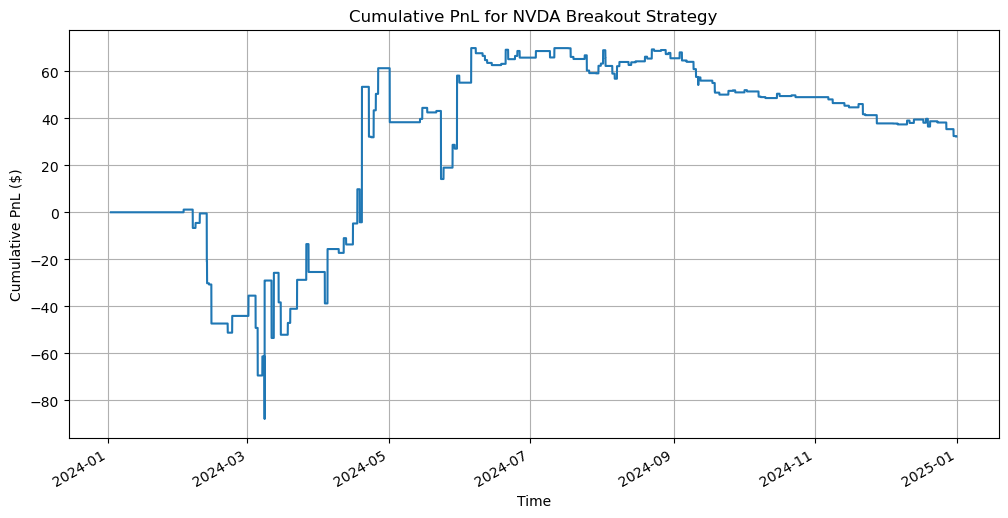

In [5]:
# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")
      # --- Plot ---
    plt.figure(figsize=(12, 6))
    tesla['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")

***************************************************************************

## Trading without volume tracking

In [8]:
# --- Strategy Parameters & Costs ---
SYMBOL = "NVDA"
STOP_LOSS_PCT = 0.027
TAKE_PROFIT_PCT = 0.05
COMMISSION_PER_TRADE = 0.50  # Example cost for an entry and exit trade

# --- Initialize Alpaca Data Client ---
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch Historical Data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2025, 1, 1)
)
bars = data_client.get_stock_bars(request)
df = bars.df
print("Data fetched successfully.")

# --- Clean & Prepare Data ---
if df.empty:
    raise ValueError("No data returned from Alpaca. Check symbol and date range.")

tesla = df.copy()
if isinstance(df.index, pd.MultiIndex):
    tesla = df[df.index.get_level_values('symbol') == SYMBOL].copy()
    tesla.index = tesla.index.droplevel('symbol')

tesla.index = tesla.index.tz_convert("America/New_York")
tesla = tesla.rename(columns={
    "open": "Open", "high": "High", "low": "Low",
    "close": "Close", "volume": "Volume"
})
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# --- Backtesting Loop ---
print("Running backtest...")
grouped = tesla.groupby(tesla.index.date)
trades = []

for date, group in grouped:
    group = group.sort_index()

    opening_range = group.between_time("09:30", "10:00")
    after_opening = group.between_time("10:01", "16:00")

    if opening_range.empty or after_opening.empty:
        continue

    high_or = opening_range['High'].max()
    low_or = opening_range['Low'].min()
    or_range = high_or - low_or
    or_pct = or_range / low_or if low_or > 0 else 0

    threshold = 0.02 if or_pct < 0.01 else 0.01
    long_break_price = high_or * (1 + threshold)
    short_break_price = low_or * (1 - threshold)

    long_trade_done = short_trade_done = False

    for i in range(len(after_opening)):
        row = after_opening.iloc[i]
        idx = after_opening.index[i]

        # --- LONG TRADE ---
        if not long_trade_done and row['High'] >= long_break_price:
            entry_price = row['Close']
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            max_price = entry_price
            tesla.at[idx, 'Position'] = 'Long'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                max_price = max(max_price, forward['High'])
                trailing_stop = max_price * (1 - TAKE_PROFIT_PCT)

                if forward['Low'] <= stop_loss or forward['Low'] <= trailing_stop:
                    exit_price = min(stop_loss, trailing_stop) if forward['Low'] <= trailing_stop else stop_loss
                    pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                    break
            else:
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Long'})
            long_trade_done = True

        # --- SHORT TRADE ---
        elif not short_trade_done and row['Low'] <= short_break_price:
            entry_price = row['Close']
            stop_loss = entry_price * (1 + STOP_LOSS_PCT)
            min_price = entry_price
            tesla.at[idx, 'Position'] = 'Short'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                min_price = min(min_price, forward['Low'])
                trailing_stop = min_price * (1 + TAKE_PROFIT_PCT)

                if forward['High'] >= stop_loss or forward['High'] >= trailing_stop:
                    exit_price = max(stop_loss, trailing_stop) if forward['High'] >= trailing_stop else stop_loss
                    pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                    break
            else:
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Short'})
            short_trade_done = True

        if long_trade_done and short_trade_done:
            break

print("Backtest finished.")


Fetching 1-minute historical data for NVDA...
Data fetched successfully.
Running backtest...
Backtest finished.



--- Trade Summary ---
Total Trades: 151
Winning %: 41.72%
Total PnL: $37.09
Average PnL: $0.25


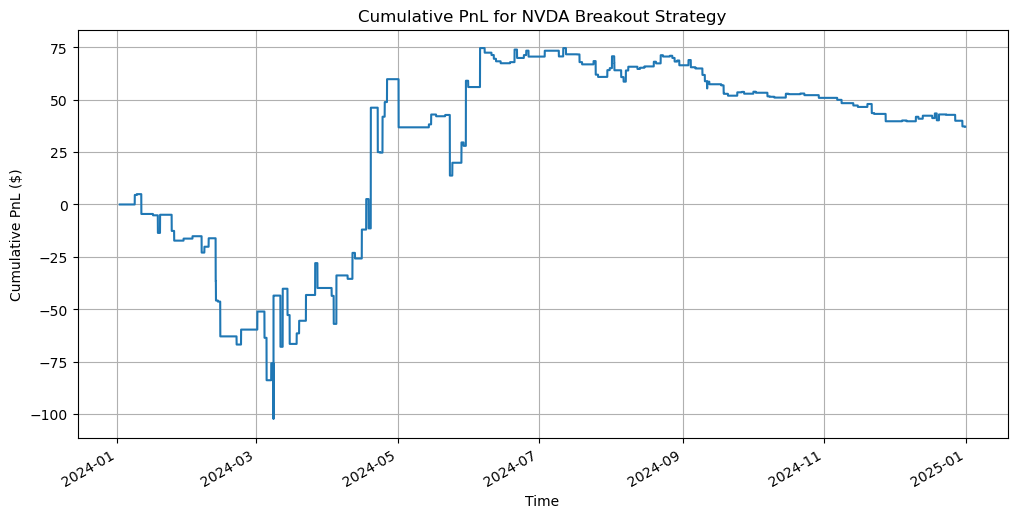

In [9]:
# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")
      # --- Plot ---
    plt.figure(figsize=(12, 6))
    tesla['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")

****************************************************************

## Adjusted for mean reversion for TSLA stock

In [10]:
# --- Strategy Parameters & Costs ---
SYMBOL = "NVDA"
STOP_LOSS_PCT = 0.027
TAKE_PROFIT_PCT = 0.05
COMMISSION_PER_TRADE = 0.50

# --- New Parameters for Trend Filter ---
FAST_MA_PERIOD = 20
SLOW_MA_PERIOD = 50

# --- Initialize Alpaca Data Client ---
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch Historical Data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2025, 1, 1)
)
bars = data_client.get_stock_bars(request)
df = bars.df
print("Data fetched successfully.")

# --- Clean & Prepare Data ---
if df.empty:
    raise ValueError("No data returned from Alpaca. Check symbol and date range.")

tesla = df.copy()
if isinstance(df.index, pd.MultiIndex):
    tesla = df[df.index.get_level_values('symbol') == SYMBOL].copy()
    tesla.index = tesla.index.droplevel('symbol')

tesla.index = tesla.index.tz_convert("America/New_York")
tesla = tesla.rename(columns={
    "open": "Open", "high": "High", "low": "Low",
    "close": "Close", "volume": "Volume"
})
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# --- Add Trend-Following Indicator (Moving Averages) ---
print("Calculating moving averages for trend filter...")
tesla['fast_ma'] = tesla['Close'].rolling(window=FAST_MA_PERIOD).mean()
tesla['slow_ma'] = tesla['Close'].rolling(window=SLOW_MA_PERIOD).mean()

# --- Backtesting Loop (Original Breakout Strategy + Trend Filter) ---
print("Running backtest with Trend-Filtered Breakout Strategy...")
grouped = tesla.groupby(tesla.index.date)
trades = []

for date, group in grouped:
    group = group.sort_index()

    # Skip days with insufficient data to calculate MAs
    if group['slow_ma'].isna().all():
        continue

    opening_range = group.between_time("09:30", "10:00")
    after_opening = group.between_time("10:01", "16:00")

    if opening_range.empty or after_opening.empty:
        continue

    high_or = opening_range['High'].max()
    low_or = opening_range['Low'].min()
    or_range = high_or - low_or
    or_pct = or_range / low_or if low_or > 0 else 0

    threshold = 0.02 if or_pct < 0.01 else 0.01
    long_break_price = high_or * (1 + threshold)
    short_break_price = low_or * (1 - threshold)

    long_trade_done = short_trade_done = False

    for i in range(len(after_opening)):
        row = after_opening.iloc[i]
        idx = after_opening.index[i]

        # Define trend condition at the moment of the potential trade
        is_uptrend = row['fast_ma'] > row['slow_ma']
        is_downtrend = row['fast_ma'] < row['slow_ma']

        # --- LONG TRADE (Only if in an uptrend) ---
        if not long_trade_done and row['High'] >= long_break_price and is_uptrend:
            entry_price = row['Close']
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            max_price = entry_price
            tesla.at[idx, 'Position'] = 'Long'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                max_price = max(max_price, forward['High'])
                trailing_stop = max_price * (1 - TAKE_PROFIT_PCT)

                if forward['Low'] <= stop_loss or forward['Low'] <= trailing_stop:
                    exit_price = min(stop_loss, trailing_stop) if forward['Low'] <= trailing_stop else stop_loss
                    pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                    break
            else:
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Long'})
            long_trade_done = True

        # --- SHORT TRADE (Only if in a downtrend) ---
        elif not short_trade_done and row['Low'] <= short_break_price and is_downtrend:
            entry_price = row['Close']
            stop_loss = entry_price * (1 + STOP_LOSS_PCT)
            min_price = entry_price
            tesla.at[idx, 'Position'] = 'Short'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                min_price = min(min_price, forward['Low'])
                trailing_stop = min_price * (1 + TAKE_PROFIT_PCT)

                if forward['High'] >= stop_loss or forward['High'] >= trailing_stop:
                    exit_price = max(stop_loss, trailing_stop) if forward['High'] >= trailing_stop else stop_loss
                    pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                    break
            else:
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Short'})
            short_trade_done = True

        if long_trade_done or short_trade_done: # Exit day's loop after one trade
            break

print("Backtest finished.")

Fetching 1-minute historical data for NVDA...
Data fetched successfully.
Calculating moving averages for trend filter...
Running backtest with Trend-Filtered Breakout Strategy...
Backtest finished.



--- Trade Summary ---
Total Trades: 145
Winning %: 42.07%
Total PnL: $-8.95
Average PnL: $-0.06


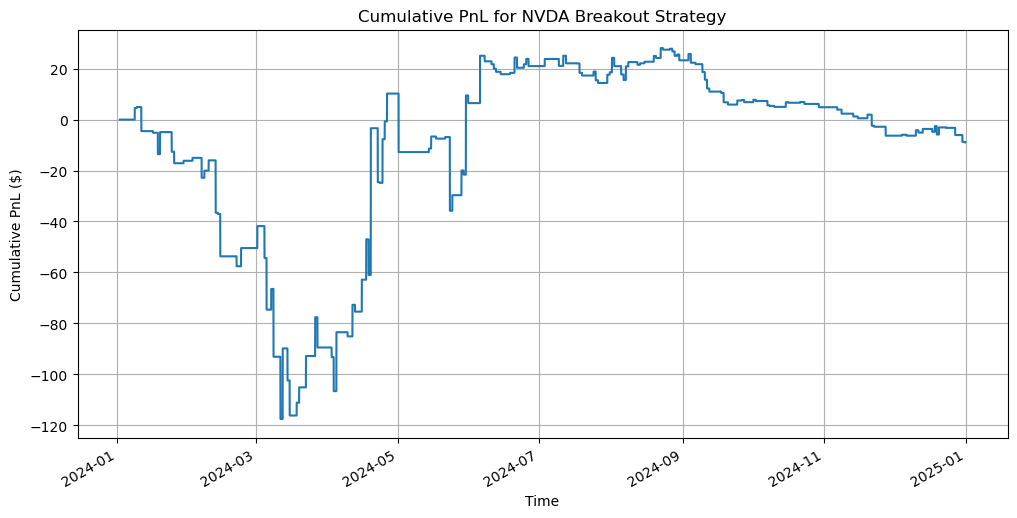

In [11]:
# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")
      # --- Plot ---
    plt.figure(figsize=(12, 6))
    tesla['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")

****************************************************************************

## Simple Optimization

In [14]:
# --- Strategy Parameters & Costs ---
SYMBOL = "NVDA"
STOP_LOSS_PCT = 0.025  # Reduced from 0.027 (NVDA has tighter intraday pullbacks)
TAKE_PROFIT_PCT = 0.06  # Increased from 0.05 (NVDA trends strongly)
COMMISSION_PER_TRADE = 0.50  # Unchanged
VOLUME_MULTIPLIER = 1.8  # Increased from 1.5 (NVDA needs higher volume confirmation)

# --- Initialize Alpaca Data Client ---
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch Historical Data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2025, 1, 1)
)
bars = data_client.get_stock_bars(request)
df = bars.df
print("Data fetched successfully.")

# --- Clean & Prepare Data ---
if df.empty:
    raise ValueError("No data returned from Alpaca. Check symbol and date range.")

nvidia = df.copy()  # Changed variable name from tesla to nvidia for clarity
if isinstance(df.index, pd.MultiIndex):
    nvidia = df[df.index.get_level_values('symbol') == SYMBOL].copy()
    nvidia.index = nvidia.index.droplevel('symbol')

nvidia.index = nvidia.index.tz_convert("America/New_York")
nvidia = nvidia.rename(columns={
    "open": "Open", "high": "High", "low": "Low",
    "close": "Close", "volume": "Volume"
})
nvidia["Position"] = "None"
nvidia["PnL"] = 0.0

# --- 20-Day Average Volume Calculation ---
print("Calculating 20-day average volume...")
daily_volume = nvidia.groupby(nvidia.index.date)['Volume'].sum()
daily_avg_vol = daily_volume.rolling(window=20).mean().shift(1)
nvidia['Day'] = nvidia.index.date
nvidia['20D_Avg_Volume'] = nvidia['Day'].map(daily_avg_vol)
nvidia = nvidia.drop(columns=['Day'])
nvidia = nvidia.ffill()

# --- Backtesting Loop ---
print("Running backtest...")
grouped = nvidia.groupby(nvidia.index.date)
trades = []

for date, group in grouped:
    group = group.sort_index()
    
    # Skip days with insufficient volume data
    if len(group) < 20 or group['20D_Avg_Volume'].isna().all():
        continue

    opening_range = group.between_time("09:30", "10:00")
    after_opening = group.between_time("10:01", "16:00")

    if opening_range.empty or after_opening.empty:
        continue

    high_or = opening_range['High'].max()
    low_or = opening_range['Low'].min()
    or_range = high_or - low_or
    or_pct = or_range / low_or if low_or > 0 else 0

    # Dynamic threshold adjustment for NVDA
    threshold = 0.018 if or_pct < 0.008 else 0.008  # Tighter thresholds for NVDA
    long_break_price = high_or * (1 + threshold)
    short_break_price = low_or * (1 - threshold)

    long_trade_done = short_trade_done = False

    for i in range(len(after_opening)):
        row = after_opening.iloc[i]
        idx = after_opening.index[i]

        # Volume threshold calculation
        vol_threshold = VOLUME_MULTIPLIER * row['20D_Avg_Volume'] / 390

        # --- LONG TRADE ---
        if (not long_trade_done and 
            row['High'] >= long_break_price and 
            row['Volume'] > vol_threshold):
            entry_price = row['Close']
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            max_price = entry_price
            nvidia.at[idx, 'Position'] = 'Long'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                max_price = max(max_price, forward['High'])
                trailing_stop = max_price * (1 - TAKE_PROFIT_PCT)

                if forward['Low'] <= stop_loss or forward['Low'] <= trailing_stop:
                    exit_price = min(stop_loss, trailing_stop) if forward['Low'] <= trailing_stop else stop_loss
                    pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                    break
            else:
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE

            nvidia.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 
                         'PnL': pnl, 'Position': 'Long'})
            long_trade_done = True

        # --- SHORT TRADE ---
        elif (not short_trade_done and 
              row['Low'] <= short_break_price and 
              row['Volume'] > vol_threshold):
            entry_price = row['Close']
            stop_loss = entry_price * (1 + STOP_LOSS_PCT)
            min_price = entry_price
            nvidia.at[idx, 'Position'] = 'Short'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                min_price = min(min_price, forward['Low'])
                trailing_stop = min_price * (1 + TAKE_PROFIT_PCT)

                if forward['High'] >= stop_loss or forward['High'] >= trailing_stop:
                    exit_price = max(stop_loss, trailing_stop) if forward['High'] >= trailing_stop else stop_loss
                    pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                    break
            else:
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE

            nvidia.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price,
                         'PnL': pnl, 'Position': 'Short'})
            short_trade_done = True

        if long_trade_done and short_trade_done:
            break

print("Backtest finished.")

Fetching 1-minute historical data for NVDA...
Data fetched successfully.
Calculating 20-day average volume...
Running backtest...
Backtest finished.



--- Trade Summary ---
Total Trades: 150
Winning %: 43.33%
Total PnL: $16.83
Average PnL: $0.11


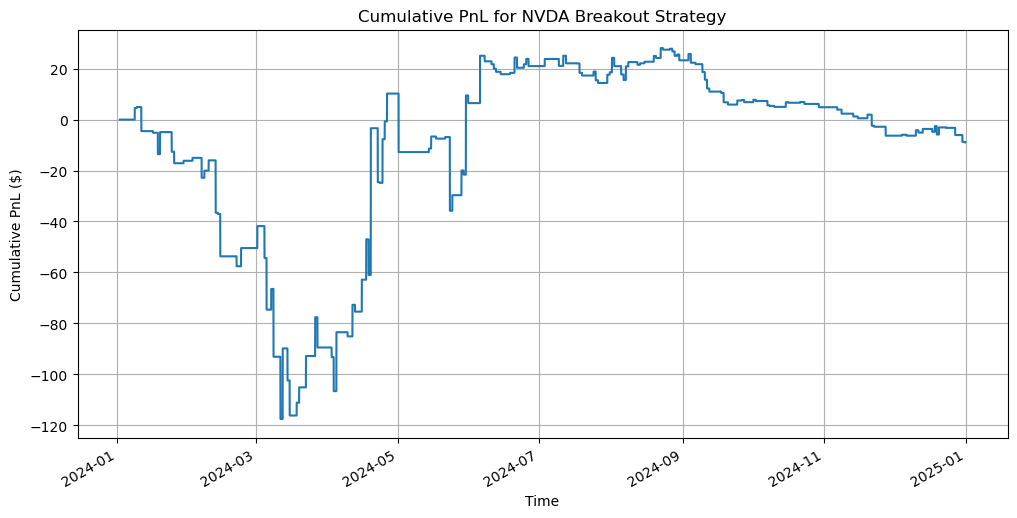

In [15]:
# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")
      # --- Plot ---
    plt.figure(figsize=(12, 6))
    tesla['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")

*****************************************************************

## Trend adjusted risk postions and dynamic thresholds

In [38]:
# --- Strategy Parameters & Costs ---
SYMBOL = "NVDA"
STOP_LOSS_PCT = 0.027
TAKE_PROFIT_PCT = 0.05
COMMISSION_PER_TRADE = 0.50

# --- New Parameters for Trend Filter ---
FAST_MA_PERIOD = 20
SLOW_MA_PERIOD = 50

# --- Position Sizes based on Trend Direction ---
LONG_BIAS_SIZE = 2
SHORT_HEDGE_SIZE = 1
SHORT_BIAS_SIZE = 2
LONG_HEDGE_SIZE = 1

data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch Historical Data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2024, 12, 30)
)
bars = data_client.get_stock_bars(request)
df = bars.df
print("Data fetched successfully.")

# --- Clean & Prepare Data ---
if df.empty:
    raise ValueError("No data returned from Alpaca. Check symbol and date range.")

tesla = df.copy()
if isinstance(df.index, pd.MultiIndex):
    tesla = df[df.index.get_level_values('symbol') == SYMBOL].copy()
    tesla.index = tesla.index.droplevel('symbol')

tesla.index = tesla.index.tz_convert("America/New_York")
tesla = tesla.rename(columns={
    "open": "Open", "high": "High", "low": "Low",
    "close": "Close", "volume": "Volume"
})
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# --- Add Trend-Following Indicator (Moving Averages) ---
print("Calculating moving averages for trend filter...")
tesla['fast_ma'] = tesla['Close'].rolling(window=FAST_MA_PERIOD).mean()
tesla['slow_ma'] = tesla['Close'].rolling(window=SLOW_MA_PERIOD).mean()

# --- Backtesting Loop (Trend-Filtered Breakout + Adaptive Threshold + Trend-Adjusted Position Size) ---
print("Running backtest with Trend-Filtered Breakout Strategy + Adaptive Thresholds...")
grouped = tesla.groupby(tesla.index.date)
trades = []

for date, group in grouped:
    group = group.sort_index()

    if group['slow_ma'].isna().all():
        continue

    opening_range = group.between_time("09:30", "10:00")
    after_opening = group.between_time("10:01", "16:00")

    if opening_range.empty or after_opening.empty:
        continue

    # Adaptive Threshold Based on Previous Day's Volatility
    prev_date = pd.Timestamp(date) - pd.Timedelta(days=1)
    if prev_date.date() in grouped.groups:
        prev_day = grouped.get_group(prev_date.date())
        if not prev_day.empty:
            prev_range = prev_day['High'].max() - prev_day['Low'].min()
            prev_volatility = prev_range / prev_day['High'].max() if prev_day['High'].max() > 0 else 0
        else:
            prev_volatility = 0.015  # Default fallback
    else:
        prev_volatility = 0.015

    # Adjust threshold adaptively (tight if low volatility, loose if high)
    if prev_volatility < 0.01:
        threshold = 0.0075
    elif prev_volatility > 0.025:
        threshold = 0.02
    else:
        threshold = 0.0125

    high_or = opening_range['High'].max()
    low_or = opening_range['Low'].min()

    long_break_price = high_or * (1 + threshold)
    short_break_price = low_or * (1 - threshold)

    long_trade_done = short_trade_done = False

    for i in range(len(after_opening)):
        row = after_opening.iloc[i]
        idx = after_opening.index[i]

        is_uptrend = row['fast_ma'] > row['slow_ma']
        is_downtrend = row['fast_ma'] < row['slow_ma']

        # --- LONG TRADE with Trend-Biased Position Sizing ---
        if not long_trade_done and row['High'] >= long_break_price and is_uptrend:
            entry_price = row['Close']
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            max_price = entry_price
            position_size = LONG_BIAS_SIZE
            hedge_size = SHORT_HEDGE_SIZE

            tesla.at[idx, 'Position'] = f'Long {position_size}, Short {hedge_size}'

            exit_price = None
            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                max_price = max(max_price, forward['High'])
                trailing_stop = max_price * (1 - TAKE_PROFIT_PCT)

                if forward['Low'] <= stop_loss or forward['Low'] <= trailing_stop:
                    exit_price = min(stop_loss, trailing_stop)
                    break

            if exit_price is None:
                exit_price = after_opening.iloc[-1]['Close']

            pnl_long = (exit_price - entry_price) * position_size
            pnl_hedge = (entry_price - exit_price) * hedge_size
            pnl = pnl_long + pnl_hedge - COMMISSION_PER_TRADE * (position_size + hedge_size)

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl,
                           'Position': f'Long {position_size}, Short {hedge_size}'})
            long_trade_done = True

        # --- SHORT TRADE with Trend-Biased Position Sizing ---
        elif not short_trade_done and row['Low'] <= short_break_price and is_downtrend:
            entry_price = row['Close']
            stop_loss = entry_price * (1 + STOP_LOSS_PCT)
            min_price = entry_price
            position_size = SHORT_BIAS_SIZE
            hedge_size = LONG_HEDGE_SIZE

            tesla.at[idx, 'Position'] = f'Short {position_size}, Long {hedge_size}'

            exit_price = None
            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                min_price = min(min_price, forward['Low'])
                trailing_stop = min_price * (1 + TAKE_PROFIT_PCT)

                if forward['High'] >= stop_loss or forward['High'] >= trailing_stop:
                    exit_price = max(stop_loss, trailing_stop)
                    break

            if exit_price is None:
                exit_price = after_opening.iloc[-1]['Close']

            pnl_short = (entry_price - exit_price) * position_size
            pnl_hedge = (exit_price - entry_price) * hedge_size
            pnl = pnl_short + pnl_hedge - COMMISSION_PER_TRADE * (position_size + hedge_size)

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl,
                           'Position': f'Short {position_size}, Long {hedge_size}'})
            short_trade_done = True

        if long_trade_done or short_trade_done:
            break

print("Backtest finished.")

Fetching 1-minute historical data for NVDA...
Data fetched successfully.
Calculating moving averages for trend filter...
Running backtest with Trend-Filtered Breakout Strategy + Adaptive Thresholds...
Backtest finished.



--- Trade Summary ---
Total Trades: 90
Winning %: 23.33%
Total PnL: $-181.00
Average PnL: $-2.01


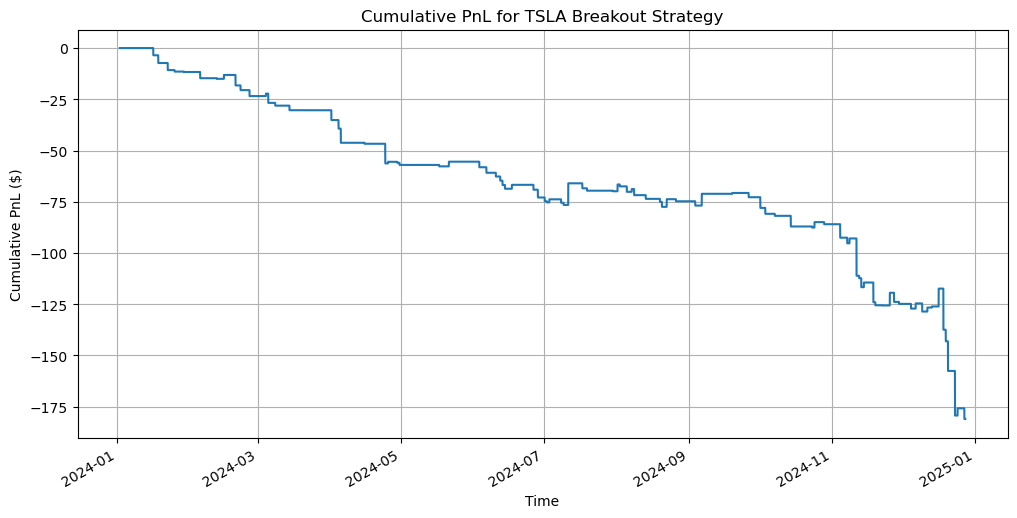

In [35]:
# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")
      # --- Plot ---
    plt.figure(figsize=(12, 6))
    tesla['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")